# Capstone: West Nile Virus

![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
#import plotly

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets

In [3]:
datadir    = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored
figdir     = '../output/figures'

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

### Load and check (\& clean) Main dataset

- Train and Test datasets:
    - Trainning sets: consists of data from 2007, 2009, 2011, and 2013
    - Test sets: predict the test results for 2008, 2010, 2012, and 2014

In [4]:
''' load the datasets '''

# load the main datasets that contain virus test results
train = pd.read_csv(os.path.join(datadir_pr, 'train_cleaned.csv'), parse_dates=['Date'], index_col='Date')
test = pd.read_csv(os.path.join(datadir_pr, 'test_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the weather data
weather = pd.read_csv(os.path.join(datadir_pr, 'weather_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the spraying data
spray = pd.read_csv(os.path.join(datadir_pr,'spray_cleaned.csv'), parse_dates=['DateTime'], index_col='DateTime')

# load the map data
mapdata = np.loadtxt(os.path.join(datadir,"mapdata_copyright_openstreetmap_contributors.txt"))
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

In [5]:
train.head(3)

Address  \
Date                                                            
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   

                           Species  Block           Street  Trap  \
Date                                                               
2007-05-29  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     62    N MANDELL AVE  T007   

                       AddressNumberAndStreet   Latitude  Longitude  \
Date                                                                  
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   

            AddressAccuracy  NumMosquitos  WnvPresent  Latitude2  Longitude2  
Date                                                                          
2007-05-29                9             1           0      41.95      -87.80  
2007-05-29                9             1           0      41.95      -87.80  
2007-05-29                9             1           0      41.99      -87.77

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
 11  Latitude2               10506 non-null  float64
 12  Longitude2              10506 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 1.1+ MB


In [7]:
weather.head(3)

Station  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  \
Date                                                                           
2007-05-01        1    83    50  67.0    14.0        51     56.0   0.0   2.0   
2007-05-01        2    84    52  68.0    14.0        51     57.0   0.0   3.0   
2007-05-02        1    59    42  51.0    -3.0        42     47.0  14.0   0.0   

            Sunrise  Sunset CodeSum  SnowFall  PrecipTotal  StnPressure  \
Date                                                                      
2007-05-01    448.0  1849.0               0.0          0.0        29.10   
2007-05-01    448.0  1849.0               0.0          0.0        29.18   
2007-05-02    447.0  1850.0      BR       0.0          0.0        29.38   

            SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
Date                                                    
2007-05-01     29.82          1.7         27       9.2  
2007-05-01     29.82          2.7         25       9.6  
2007-05-02     30.09         13.0          4      13.4

In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2944 non-null   float64
 4   Depart       2944 non-null   float64
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   float64
 7   Heat         2944 non-null   float64
 8   Cool         2944 non-null   float64
 9   Sunrise      2944 non-null   float64
 10  Sunset       2944 non-null   float64
 11  CodeSum      2944 non-null   object 
 12  SnowFall     2944 non-null   float64
 13  PrecipTotal  2944 non-null   float64
 14  StnPressure  2944 non-null   float64
 15  SeaLevel     2944 non-null   float64
 16  ResultSpeed  2944 non-null   float64
 17  ResultDir    2944 non-null   int64  
 18  AvgSpeed     2944 non-null   f

In [9]:
spray.head()

Latitude  Longitude  Latitude2  Longitude2
DateTime                                                        
2011-08-29 18:56:58  42.391623 -88.089163      42.39      -88.09
2011-08-29 18:57:08  42.391348 -88.089163      42.39      -88.09
2011-08-29 18:57:18  42.391022 -88.089157      42.39      -88.09
2011-08-29 18:57:28  42.390637 -88.089158      42.39      -88.09
2011-08-29 18:57:38  42.390410 -88.088858      42.39      -88.09

# Exploratory Data Analysis

## Check the data statistics

In [10]:
train.describe().T

count       mean        std        min        25%  \
Block            10506.0  35.687797  24.339468  10.000000  12.000000   
Latitude         10506.0  41.841139   0.112742  41.644612  41.732984   
Longitude        10506.0 -87.699908   0.096514 -87.930995 -87.760070   
AddressAccuracy  10506.0   7.819532   1.452921   3.000000   8.000000   
NumMosquitos     10506.0  12.853512  16.133816   1.000000   2.000000   
WnvPresent       10506.0   0.052446   0.222936   0.000000   0.000000   
Latitude2        10506.0  41.840221   0.112643  41.640000  41.730000   
Longitude2       10506.0 -87.700496   0.095956 -87.930000 -87.760000   

                       50%        75%        max  
Block            33.000000  52.000000  98.000000  
Latitude         41.846283  41.954690  42.017430  
Longitude       -87.694991 -87.627796 -87.531635  
AddressAccuracy   8.000000   9.000000   9.000000  
NumMosquitos      5.000000  17.000000  50.000000  
WnvPresent        0.000000   0.000000   1.000000  
Latitude2        41.850000  41.950000  42.020000  
Longitude2      -87.690000 -87.630000 -87.530000

In [11]:
spray.describe().T

count       mean       std        min        25%        50%  \
Latitude    14294.0  41.901739  0.105100  41.713925  41.782669  41.937578   
Longitude   14294.0 -87.734512  0.067599 -88.096468 -87.789607 -87.724781   
Latitude2   14294.0  41.901601  0.105110  41.710000  41.780000  41.940000   
Longitude2  14294.0 -87.734447  0.067610 -88.100000 -87.790000 -87.720000   

                  75%        max  
Latitude    41.977217  42.395983  
Longitude  -87.692107 -87.586727  
Latitude2   41.980000  42.400000  
Longitude2 -87.690000 -87.590000

In [12]:
weather.describe().T

count         mean        std      min      25%      50%  \
Station      2944.0     1.500000   0.500085     1.00     1.00     1.50   
Tmax         2944.0    76.166101  11.461970    41.00    69.00    78.00   
Tmin         2944.0    57.810462  10.381939    29.00    50.00    59.00   
Tavg         2944.0    67.239300  10.538784    36.00    60.00    69.00   
Depart       2944.0     1.954484   6.839947   -17.00    -3.00     2.00   
DewPoint     2944.0    53.457880  10.675181    22.00    46.00    54.00   
WetBulb      2944.0    59.321671   9.286075    32.00    53.00    61.00   
Heat         2944.0     3.417799   5.955153     0.00     0.00     0.00   
Cool         2944.0     5.641304   6.104849     0.00     0.00     4.00   
Sunrise      2944.0   480.646739  65.333626   416.00   424.75   446.50   
Sunset       2944.0  1847.347826  87.035824  1647.00  1792.25  1859.50   
SnowFall     2944.0     0.000068   0.002606     0.00     0.00     0.00   
PrecipTotal  2944.0     0.144837   0.402131     0.00     0.00     0.00   
StnPressure  2944.0    29.284446   0.158468    28.55    29.19    29.28   
SeaLevel     2944.0    29.968356   0.158512    29.23    29.87    29.97   
ResultSpeed  2944.0     6.960666   3.587527     0.10     4.30     6.40   
ResultDir    2944.0    17.494905  10.063609     1.00     7.00    19.00   
AvgSpeed     2944.0     8.579076   3.146201     1.70     6.30     8.10   

                 75%      max  
Station         2.00     2.00  
Tmax           85.00   104.00  
Tmin           66.00    83.00  
Tavg           75.00    94.00  
Depart          7.00    23.00  
DewPoint       62.00    75.00  
WetBulb        67.00    78.00  
Heat            5.00    29.00  
Cool           10.00    29.00  
Sunrise       531.25   623.00  
Sunset       1922.25  1931.00  
SnowFall        0.00     0.10  
PrecipTotal     0.09     6.86  
StnPressure    29.39    29.86  
SeaLevel       30.06    30.53  
ResultSpeed     9.20    24.10  
ResultDir      25.00    36.00  
AvgSpeed       10.40    26.30

## plotting traps and spray locations on map

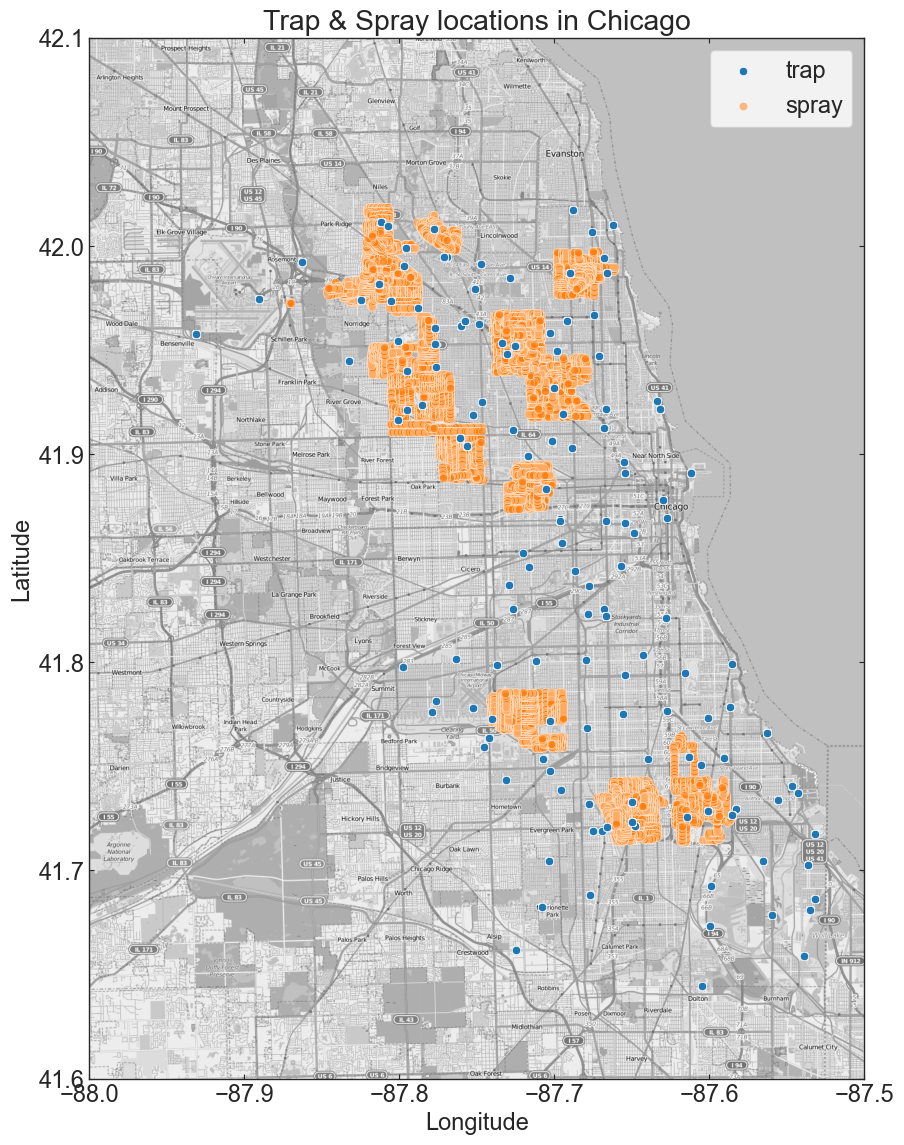

In [13]:
fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), \
          extent=lon_lat_box, aspect=aspect)

trap_locations  = train[['Longitude', 'Latitude']].values
spray_locations = spray[['Longitude', 'Latitude']].values
sns.scatterplot(x=trap_locations[:,0], y=trap_locations[:,1], label='trap', ax=ax, zorder=1)
sns.scatterplot(x=spray_locations[:,0], y=spray_locations[:,1], label='spray', alpha=0.5, ax=ax, zorder=0)
ax.set_xlim(lon_lat_box[:2])
ax.set_ylim(lon_lat_box[2:])
ax.set(xlabel='Longitude', ylabel='Latitude', title='Trap & Spray locations in Chicago');

## plotting number of mosquitos and areas where West Nile Virus is present

In [14]:
n_mosquitos = train.groupby(['Address'], as_index=False)[['NumMosquitos']].sum()
n_mosquitos

Address  NumMosquitos
0        1000 East 67th Street, Chicago, IL 60637, USA           852
1    1000 North Central Park Avenue, Chicago, IL 60...          1802
2    1000 South California Avenue, Chicago, IL 6061...           125
3        1000 West 95th Street, Chicago, IL 60643, USA           185
4    1100 North Artesian Avenue, Chicago, IL 60622,...           666
..                                                 ...           ...
133           South Vincennes Avenue, Chicago, IL, USA           374
134             South Wallace Street, Chicago, IL, USA            28
135  University of Illinois at Chicago, 1100 South ...          1685
136                  West 37th Place, Chicago, IL, USA            47
137          West Garfield Boulevard, Chicago, IL, USA           848

[138 rows x 2 columns]

In [15]:
areas = train.groupby(['Address'], as_index=False)[['Latitude','Longitude']].median()
areas

Address   Latitude  Longitude
0        1000 East 67th Street, Chicago, IL 60637, USA  41.773215 -87.600880
1    1000 North Central Park Avenue, Chicago, IL 60...  41.899230 -87.716788
2    1000 South California Avenue, Chicago, IL 6061...  41.869107 -87.696293
3        1000 West 95th Street, Chicago, IL 60643, USA  41.721474 -87.648064
4    1100 North Artesian Avenue, Chicago, IL 60622,...  41.903002 -87.688267
..                                                 ...        ...        ...
133           South Vincennes Avenue, Chicago, IL, USA  41.723195 -87.649970
134             South Wallace Street, Chicago, IL, USA  41.753411 -87.639817
135  University of Illinois at Chicago, 1100 South ...  41.868077 -87.666901
136                  West 37th Place, Chicago, IL, USA  41.825902 -87.667827
137          West Garfield Boulevard, Chicago, IL, USA  41.793818 -87.654234

[138 rows x 3 columns]

In [16]:
''' the total cases of West Nile Virus for the Addresses '''
wnv = train.groupby(['Address'], as_index=False)[['WnvPresent']].sum()
wnv

Address  WnvPresent
0        1000 East 67th Street, Chicago, IL 60637, USA           4
1    1000 North Central Park Avenue, Chicago, IL 60...           8
2    1000 South California Avenue, Chicago, IL 6061...           0
3        1000 West 95th Street, Chicago, IL 60643, USA           1
4    1100 North Artesian Avenue, Chicago, IL 60622,...           4
..                                                 ...         ...
133           South Vincennes Avenue, Chicago, IL, USA           4
134             South Wallace Street, Chicago, IL, USA           0
135  University of Illinois at Chicago, 1100 South ...           7
136                  West 37th Place, Chicago, IL, USA           0
137          West Garfield Boulevard, Chicago, IL, USA           4

[138 rows x 2 columns]

In [17]:
nmos_areas_wnv = pd.concat([n_mosquitos, areas, wnv], axis=1).drop(columns=['Address'])
nmos_areas_wnv

NumMosquitos   Latitude  Longitude  WnvPresent
0             852  41.773215 -87.600880           4
1            1802  41.899230 -87.716788           8
2             125  41.869107 -87.696293           0
3             185  41.721474 -87.648064           1
4             666  41.903002 -87.688267           4
..            ...        ...        ...         ...
133           374  41.723195 -87.649970           4
134            28  41.753411 -87.639817           0
135          1685  41.868077 -87.666901           7
136            47  41.825902 -87.667827           0
137           848  41.793818 -87.654234           4

[138 rows x 4 columns]

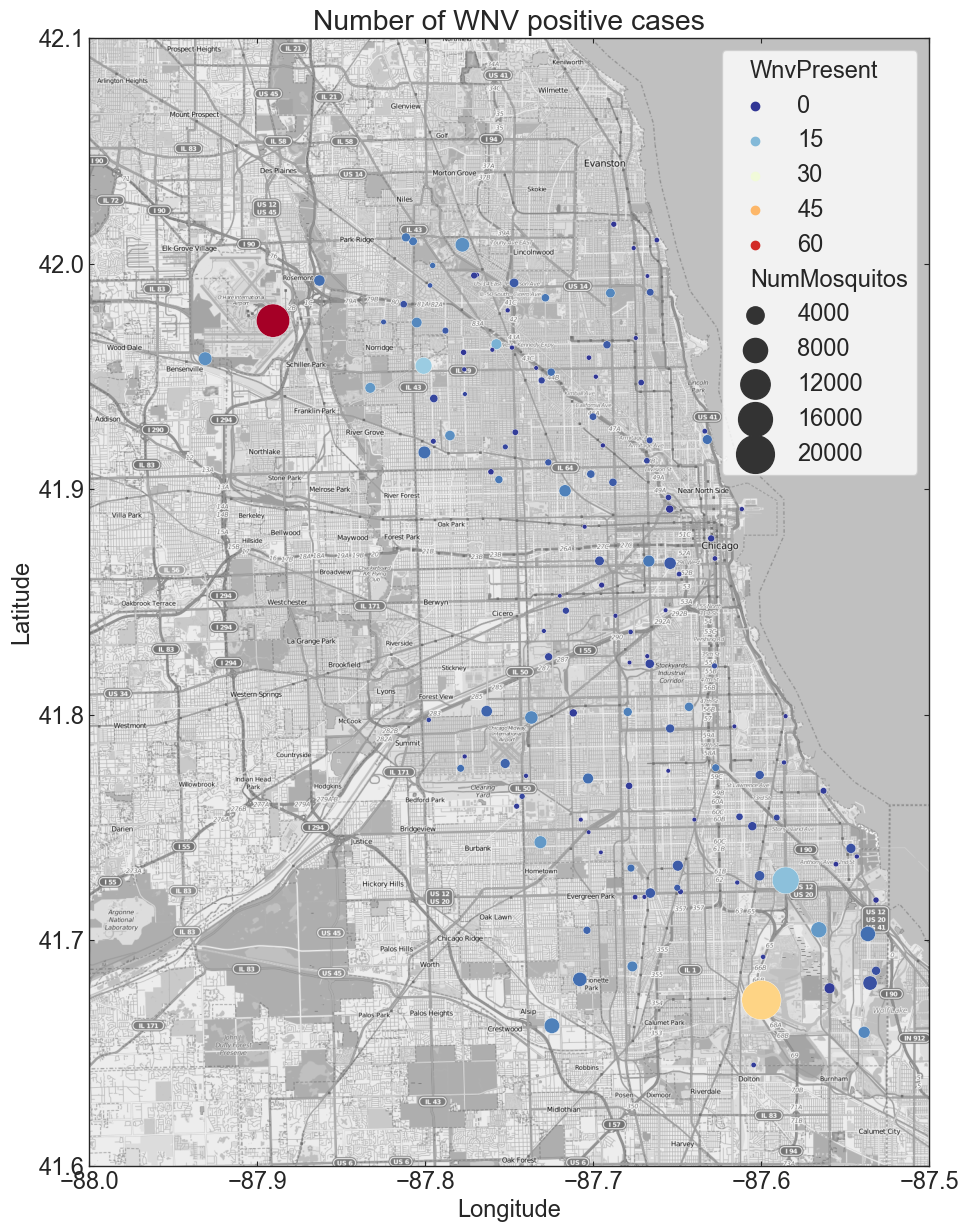

In [20]:
fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), \
          extent=lon_lat_box, aspect=aspect)

#trap_locations  = train[['Longitude', 'Latitude']].values
#spray_locations = spray[['Longitude', 'Latitude']].values
sns.scatterplot(x='Longitude', y='Latitude', data=nmos_areas_wnv, \
                size='NumMosquitos', sizes=(10,800), hue='WnvPresent', palette='RdYlBu_r', ax=ax)
ax.set_xlim(lon_lat_box[:2])
ax.set_ylim(lon_lat_box[2:])
ax.set(xlabel='Longitude', ylabel='Latitude', title='Number of WNV positive cases')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'Map_num_mos_positive.png'));

## WNV by month or year

In [21]:
''' the total cases of West Nile Virus for the Addresses '''
wnv_year = train.groupby([train.index.year])[['WnvPresent']].sum()
wnv_year

WnvPresent
Date            
2007         236
2009          19
2011          57
2013         239

In [22]:
''' the total cases of West Nile Virus for the Addresses '''
wnv_year_month = train.groupby([train.index.year, train.index.month])[['WnvPresent']].sum()
wnv_year_month

WnvPresent
Date Date            
2007 5              0
     6              0
     7              6
     8            200
     9             28
     10             2
2009 5              0
     6              0
     7              5
     8              9
     9              5
     10             0
2011 6              0
     7             11
     8             24
     9             22
2013 6              1
     7             24
     8            144
     9             70

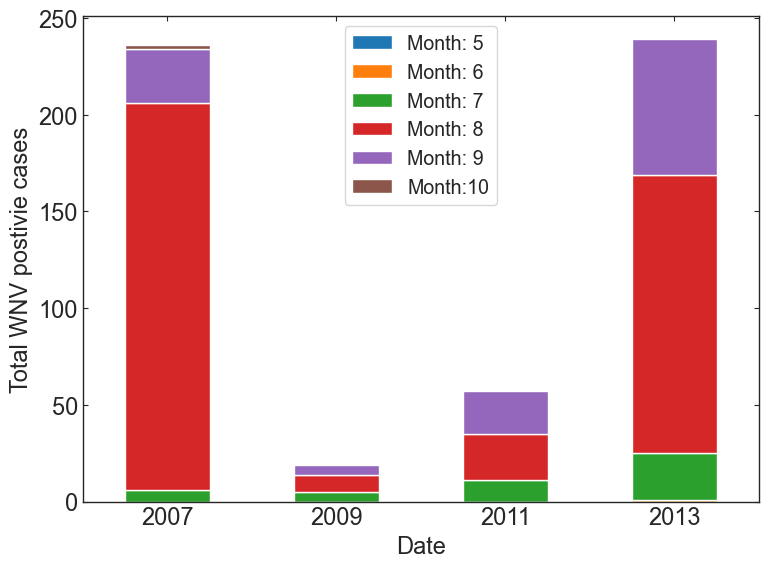

In [23]:
fig, ax = plt.subplots()

wnv_year_month.unstack().plot(kind='bar', stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()

labels = ['Month:{}'.format(ilabel[-3:-1]) for ilabel in labels ]
labels

ax.legend(handles, labels, loc='best', fontsize='small')
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel('Total WNV postivie cases')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'WNV_positive_month.png'));

## Overplot the spray data
- Check the effectiveness of the spraying if it reduces the virus and the number of mosquitos

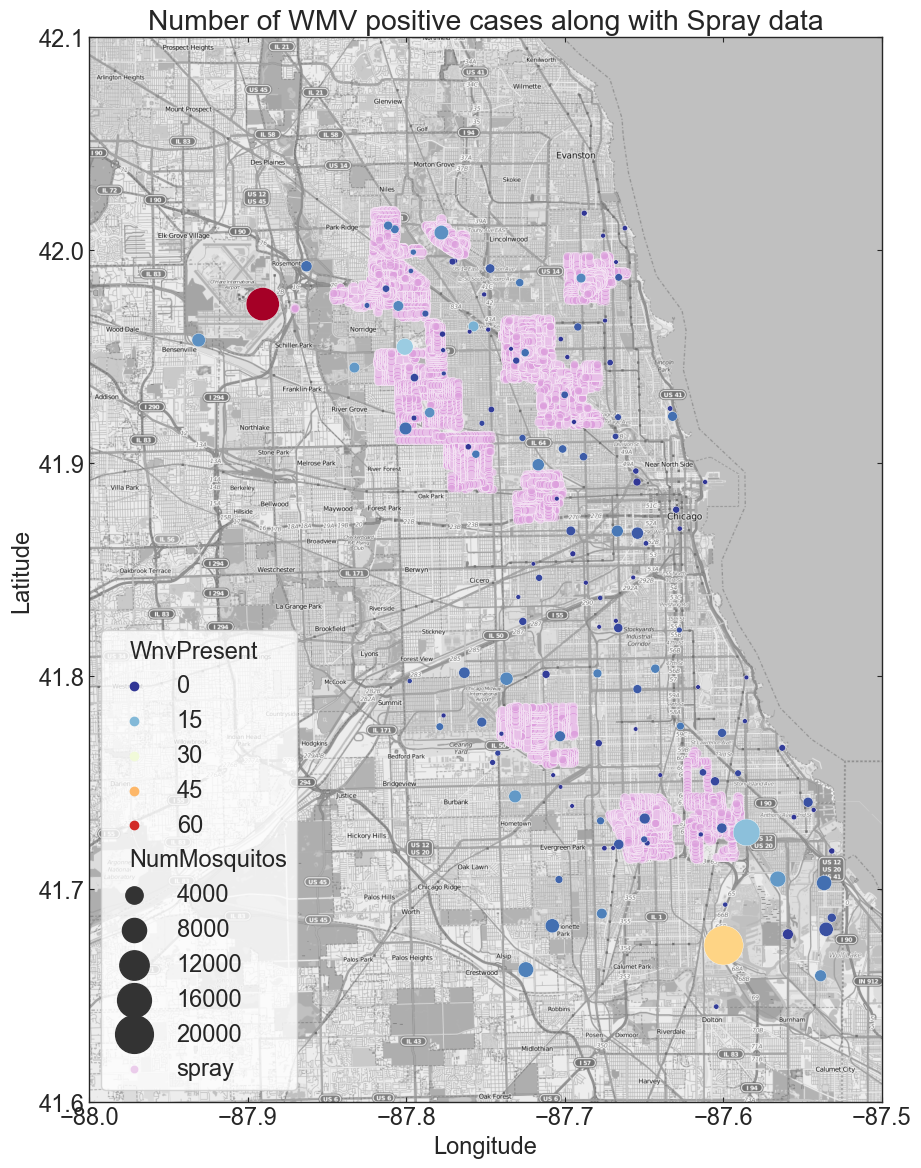

In [25]:
fig, ax = plt.subplots(figsize=(10,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), \
          extent=lon_lat_box, aspect=aspect)

#trap_locations  = train[['Longitude', 'Latitude']].values
#spray_locations = spray[['Longitude', 'Latitude']].values
sns.scatterplot(x='Longitude', y='Latitude', data=nmos_areas_wnv, \
                size='NumMosquitos', sizes=(10,800), hue='WnvPresent', palette='RdYlBu_r', ax=ax)

sns.scatterplot(x='Longitude', y='Latitude', data=spray, label='spray', color='plum', alpha=0.5, ax=ax, zorder=0)

ax.set_xlim(lon_lat_box[:2])
ax.set_ylim(lon_lat_box[2:])
ax.set(xlabel='Longitude', ylabel='Latitude', title='Number of WMV positive cases along with Spray data')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'Map_num_mos_positive_w_spray.png'));

> It is apparent that the spraying seems effective to control the number of mosquitos. It shows that the sprayed area has less virus as well as mosquitos that can carry the virus. 

## Analyzing the species of the mosquito

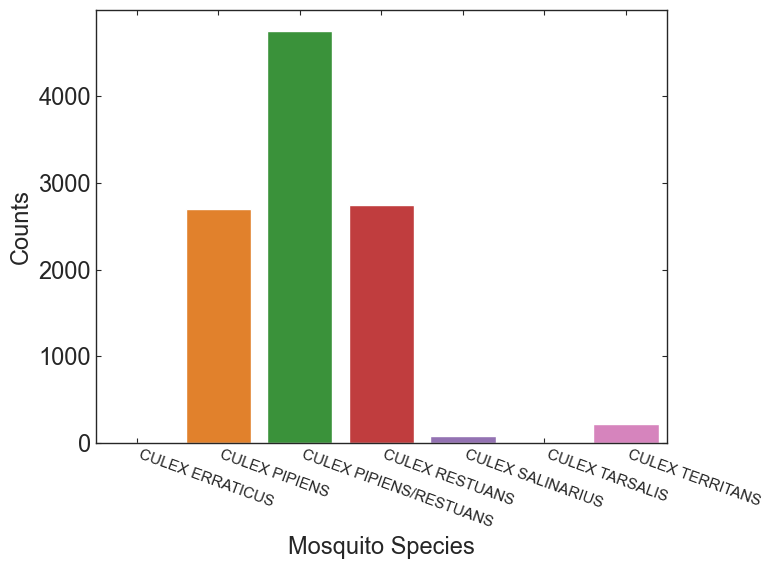

In [29]:
''' draw total counts of trapped mosquitos '''
fig, ax = plt.subplots()
species_list = np.sort(train.Species.unique())

sns.countplot(x='Species', data=train, order=species_list, ax=ax)
ax.tick_params(axis='x', labelrotation=-20, labelsize=11)
ax.set(xlabel='Mosquito Species', ylabel='Counts')

plt.setp(ax.get_xticklabels(), ha="left") # horizontalalignment is not developed in tick_params()

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'num_mos_speices.png'));  

> Culex Pipiens is the most dominant species for the trapped mosquitos.

In [30]:
mos_virus = train[['Species','WnvPresent']].groupby('Species', as_index=False).sum()
mos_virus

Species  WnvPresent
0         CULEX ERRATICUS           0
1           CULEX PIPIENS         240
2  CULEX PIPIENS/RESTUANS         262
3          CULEX RESTUANS          49
4        CULEX SALINARIUS           0
5          CULEX TARSALIS           0
6         CULEX TERRITANS           0

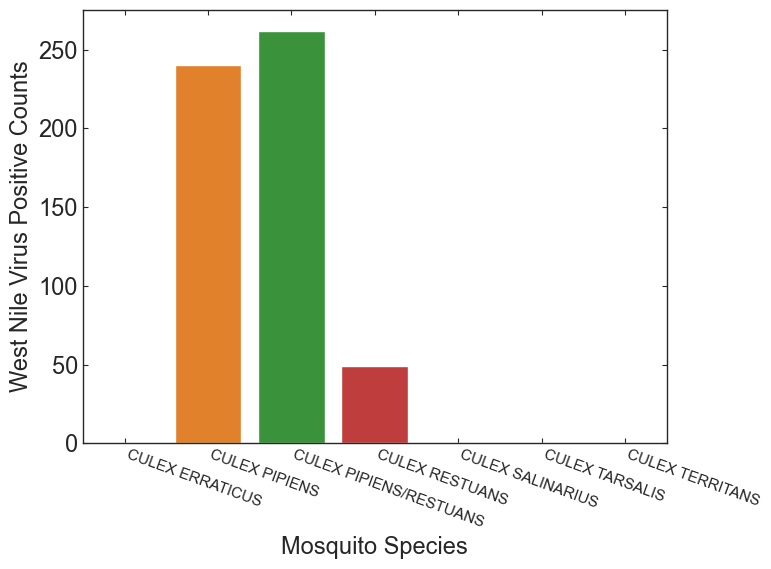

In [33]:
fig, ax = plt.subplots()
sns.barplot(x='Species', y='WnvPresent', data=mos_virus, ax=ax)
ax.tick_params(axis='x', labelrotation=-20, labelsize=11)
ax.set(xlabel='Mosquito Species', ylabel='West Nile Virus Positive Counts')

plt.setp(ax.get_xticklabels(), ha="left")  # horizontalalignment is not developed in tick_params()

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'WNV_positive_species.png'));

> There are 2 species that carry the West Nile virus: Culex Pipiens, Culex Restuans. The plot shows that Culex Pipiens is the most dominant carrier. 

## Check the average temperatures for the different years

In [34]:
weather['Year'] = weather.index.year

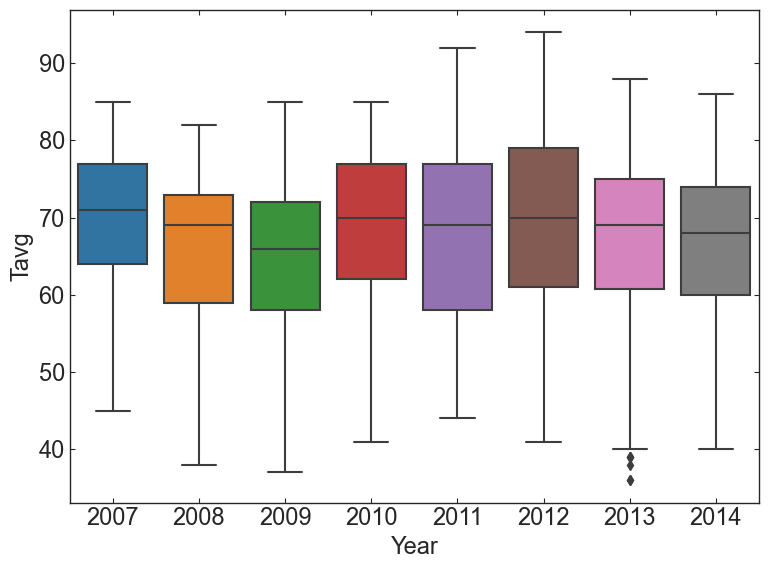

In [35]:
fig, ax = plt.subplots()

sns.boxplot(x=weather.Year, y=weather.Tavg, ax=ax)

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'Tavg_year.png'));  

> The average temperature is approximately 70 degree in Fehrenheit.

## Check the correlation between Temperature and the number of mosquitos & Virus presence

In [36]:
Tavg_bydate = weather.groupby('Date')[['Tavg']].mean()
Tavg_bydate

Tavg
Date             
2007-05-01  67.50
2007-05-02  51.50
2007-05-03  57.00
2007-05-04  61.25
2007-05-05  60.00
...           ...
2014-10-27  65.50
2014-10-28  57.00
2014-10-29  44.00
2014-10-30  43.50
2014-10-31  41.00

[1472 rows x 1 columns]

In [37]:
nmos_bydate = train.groupby('Date')[['NumMosquitos']].sum()
nmos_bydate

NumMosquitos
Date                    
2007-05-29            40
2007-06-05           127
2007-06-26           216
2007-06-29            85
2007-07-02           240
...                  ...
2013-08-29          2645
2013-09-06          2510
2013-09-12          2210
2013-09-19          1030
2013-09-26           505

[95 rows x 1 columns]

In [38]:
wnv_bydate = train.groupby('Date')[['WnvPresent']].sum()
wnv_bydate

WnvPresent
Date                  
2007-05-29           0
2007-06-05           0
2007-06-26           0
2007-06-29           0
2007-07-02           0
...                ...
2013-08-29          38
2013-09-06          32
2013-09-12          23
2013-09-19          11
2013-09-26           4

[95 rows x 1 columns]

In [39]:
''' merge dataset '''

nmos_wnv = pd.merge(nmos_bydate, wnv_bydate, on='Date')
nmos_wnv_Tavg = pd.merge(nmos_wnv, Tavg_bydate, on='Date', how='inner')

nmos_wnv_Tavg

NumMosquitos  WnvPresent  Tavg
Date                                      
2007-05-29            40           0  75.5
2007-06-05           127           0  56.5
2007-06-26           216           0  81.5
2007-06-29            85           0  63.5
2007-07-02           240           0  67.0
...                  ...         ...   ...
2013-08-29          2645          38  78.0
2013-09-06          2510          32  73.0
2013-09-12          2210          23  72.5
2013-09-19          1030          11  77.0
2013-09-26           505           4  64.0

[95 rows x 3 columns]

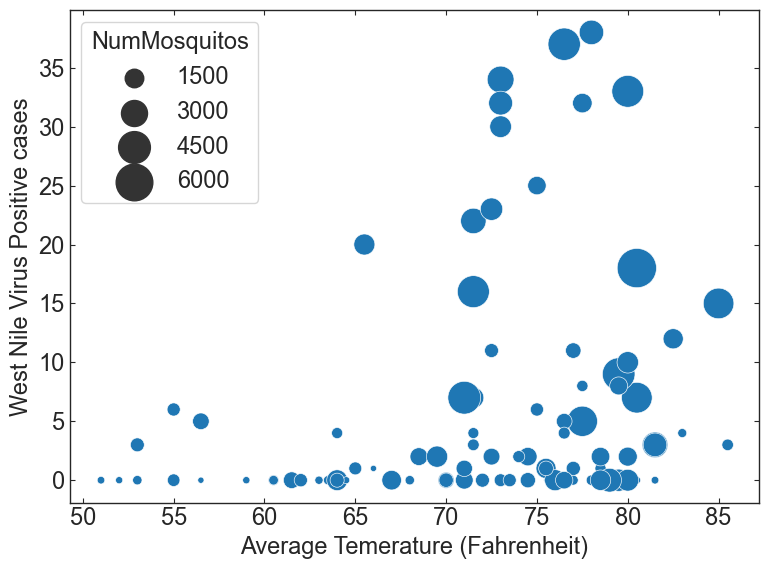

In [41]:
fig, ax = plt.subplots()

sns.scatterplot(x='Tavg', y='WnvPresent', data=nmos_wnv_Tavg, size='NumMosquitos', sizes=(10,800), ax=ax)
ax.set(xlabel='Average Temerature (Fahrenheit)', ylabel='West Nile Virus Positive cases')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'WNV_positive_Tavg.png'));

> It is apparent that mosquitos and West Nile virus are more prevalent in higher temperature. 

## Check the correlation between features in weather + train data

In [46]:
train.head()

Address  \
Date                                                            
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                           Species  Block           Street  Trap  \
Date                                                               
2007-05-29  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2007-05-29          CULEX RESTUANS     62    N MANDELL AVE  T007   
2007-05-29  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
2007-05-29          CULEX RESTUANS     79     W FOSTER AVE  T015   

                       AddressNumberAndStreet   Latitude  Longitude  \
Date                                                                  
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2007-05-29   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
2007-05-29    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
2007-05-29    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

            AddressAccuracy  NumMosquitos  WnvPresent  Latitude2  Longitude2  
Date                                                                          
2007-05-29                9             1           0      41.95      -87.80  
2007-05-29                9             1           0      41.95      -87.80  
2007-05-29                9             1           0      41.99      -87.77  
2007-05-29                8             1           0      41.97      -87.82  
2007-05-29                8             4           0      41.97      -87.82

In [47]:
weather.head()

Station  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  \
Date                                                                           
2007-05-01        1    83    50  67.0    14.0        51     56.0   0.0   2.0   
2007-05-01        2    84    52  68.0    14.0        51     57.0   0.0   3.0   
2007-05-02        1    59    42  51.0    -3.0        42     47.0  14.0   0.0   
2007-05-02        2    60    43  52.0    -3.0        42     47.0  13.0   0.0   
2007-05-03        1    66    46  56.0     2.0        40     48.0   9.0   0.0   

            Sunrise  Sunset CodeSum  SnowFall  PrecipTotal  StnPressure  \
Date                                                                      
2007-05-01    448.0  1849.0               0.0          0.0        29.10   
2007-05-01    448.0  1849.0               0.0          0.0        29.18   
2007-05-02    447.0  1850.0      BR       0.0          0.0        29.38   
2007-05-02    447.0  1850.0   BR HZ       0.0          0.0        29.44   
2007-05-03    446.0  1851.0               0.0          0.0        29.39   

            SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  
Date                                                          
2007-05-01     29.82          1.7         27       9.2  2007  
2007-05-01     29.82          2.7         25       9.6  2007  
2007-05-02     30.09         13.0          4      13.4  2007  
2007-05-02     30.08         13.3          2      13.4  2007  
2007-05-03     30.12         11.7          7      11.9  2007

In [48]:
# Combine train data with the weather data
# note that there are two weather stations

train_weather1 = train.join(weather[weather.Station==1], how='inner')  # weather from Station 1
train_weather2 = train.join(weather[weather.Station==2], how='inner')  # weather from Station 2

In [50]:
# drop some features which has mostly null or non-values.
#drop_features = ['Water1','Depth','Heat','SnowFall','NumMosquitos','Station', \
drop_features = ['Heat','SnowFall','NumMosquitos','Station', \
                 'Latitude','Longitude','Latitude2','Longitude2','SeaLevel','Depart','Sunrise','Sunset']

train_weather1.drop(drop_features, axis=1, inplace=True)
train_weather2.drop(drop_features, axis=1, inplace=True)

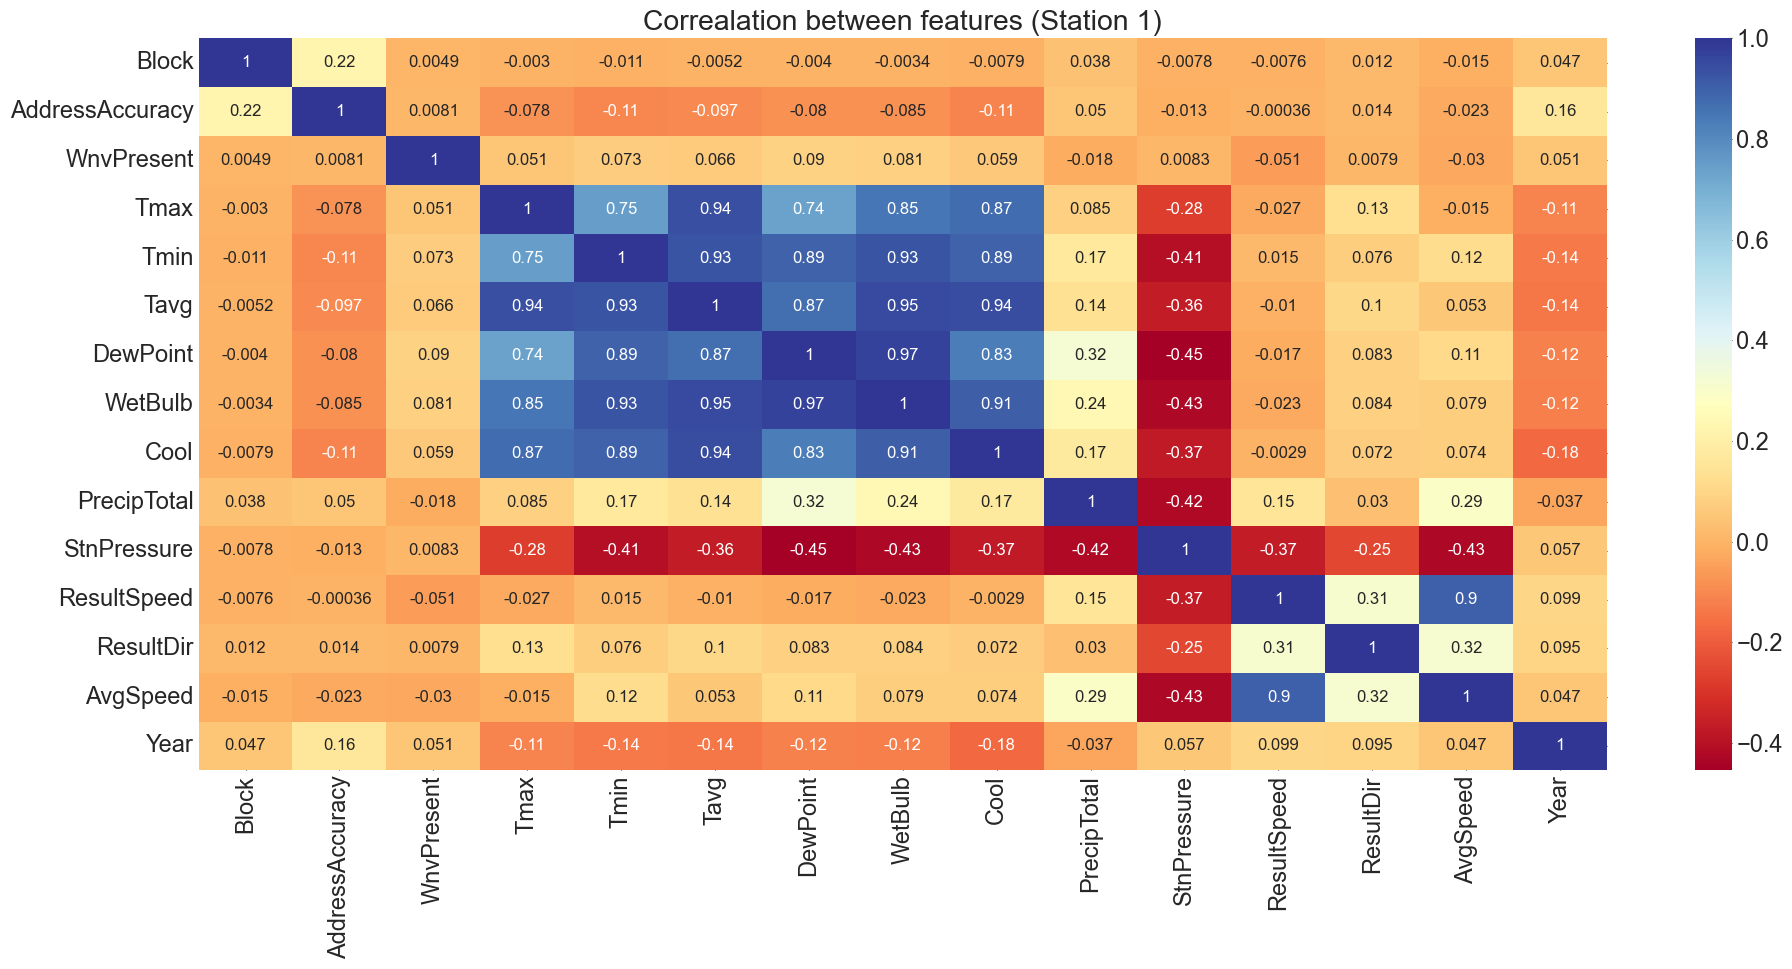

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.heatmap(train_weather1.corr(), annot=True, cmap="RdYlBu", annot_kws={"size":12}, ax = ax)
ax.set_title('Correalation between features (Station 1)')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'heatmap_station1.png'));  

> Strong correlation is seen between Temperatures (Tmin, Tmax, Tavg), DewPoint, WetBulb and Cool.

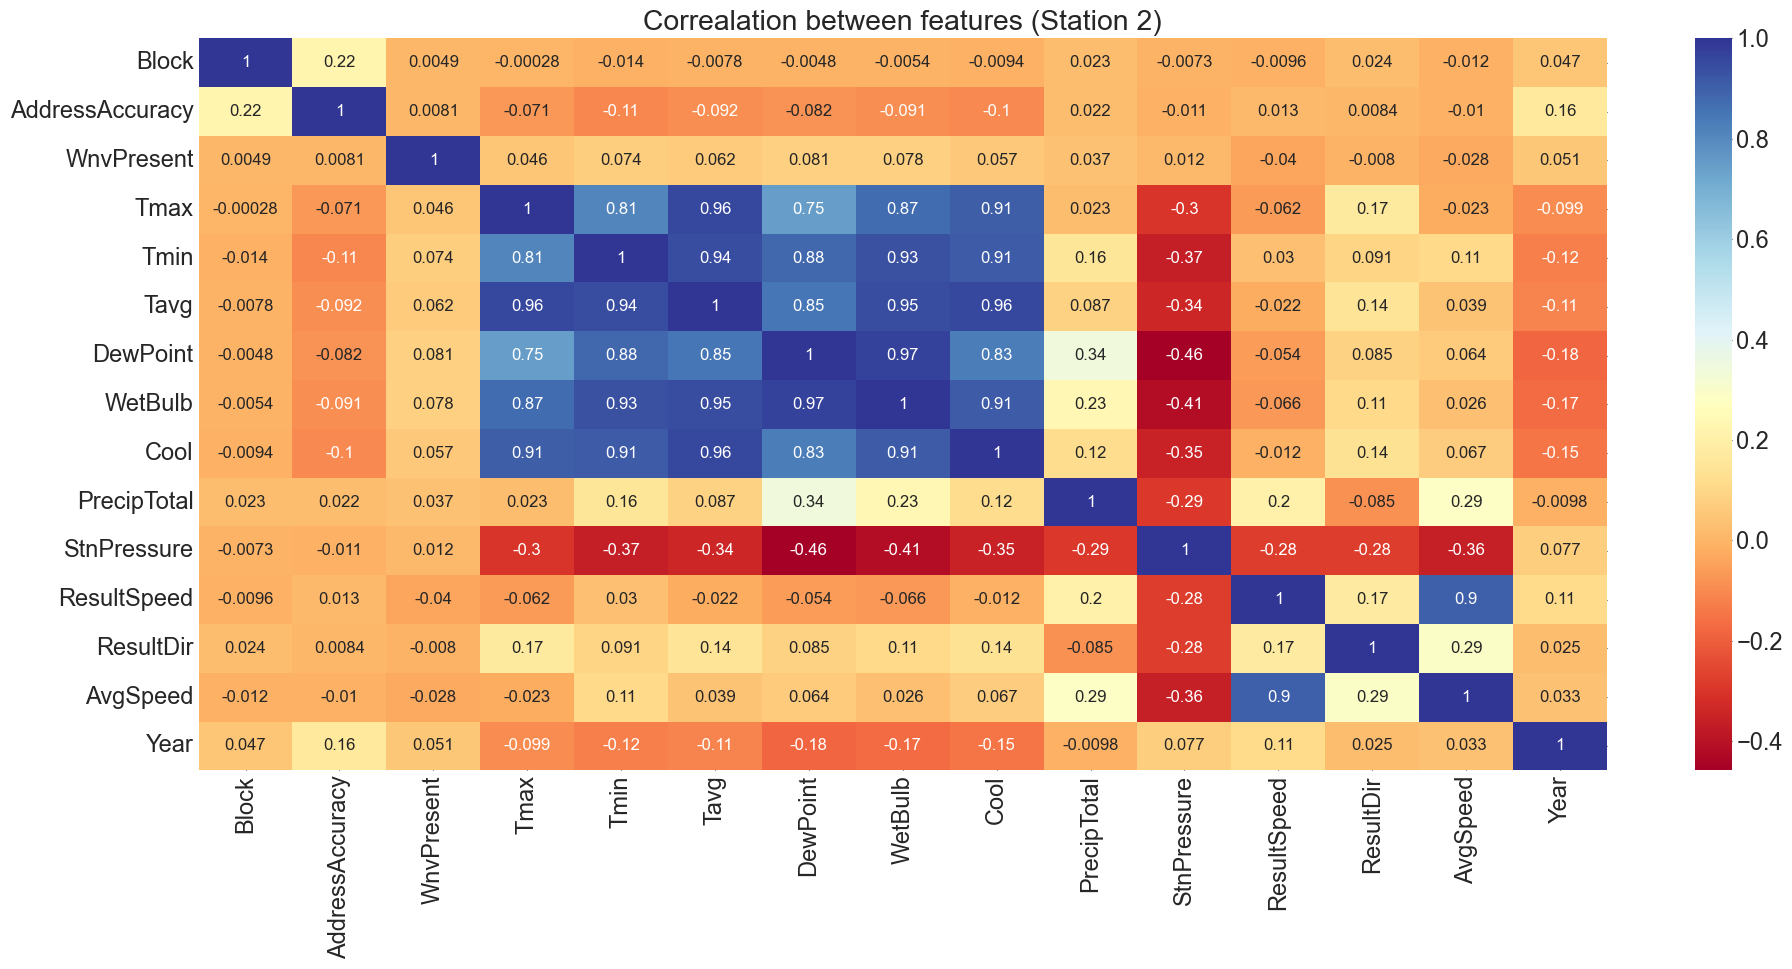

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.heatmap(train_weather2.corr(), annot=True, cmap="RdYlBu", annot_kws={"size":12}, ax = ax)
ax.set_title('Correalation between features (Station 2)')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'heatmap_station2.png'));

## Check the average temperature for the different years along with West Nile Virus cases

In [55]:
train_weather1['Year'] = train_weather1.index.year
train_weather2['Year'] = train_weather2.index.year

In [56]:
wnv_byyear = train_weather1.groupby('Year')[['WnvPresent']].sum()
wnv_byyear

WnvPresent
Year            
2007         236
2009          19
2011          57
2013         239

> This shows that West Nile Virus is mostly prevalent in 2007 and 2013.

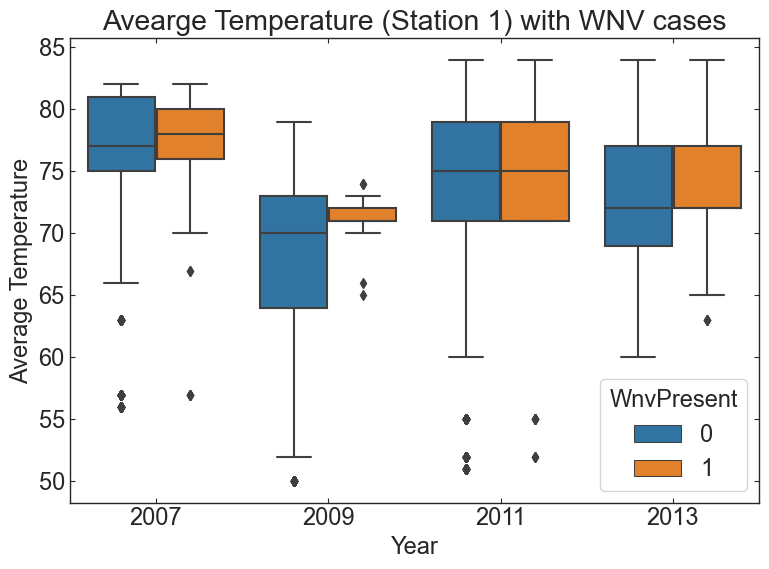

In [59]:
fig, ax = plt.subplots()
sns.boxplot(x='Year', y='Tavg', data=train_weather1, hue='WnvPresent', ax=ax)
ax.set(xlabel='Year', ylabel='Average Temperature', title='Avearge Temperature (Station 1) with WNV cases')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'Tavg_year_WNV_station1.png'));  

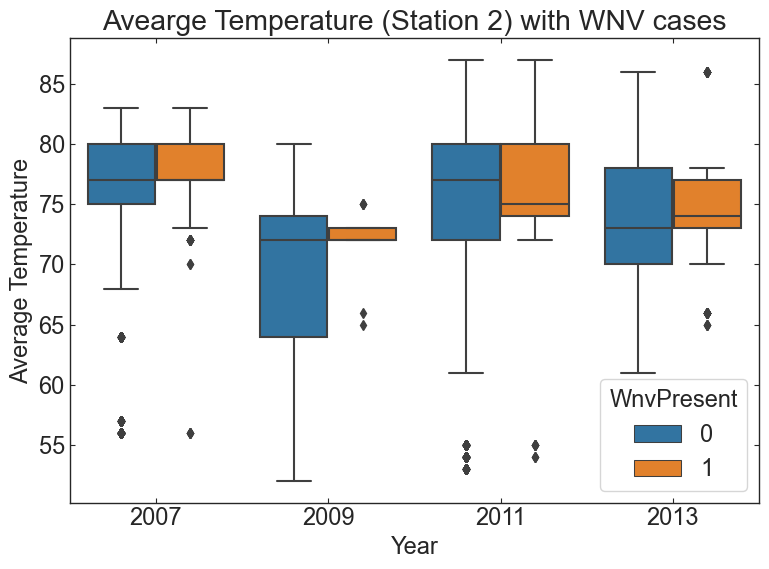

In [60]:
fig, ax = plt.subplots()
sns.boxplot(x='Year', y='Tavg', data=train_weather2, hue='WnvPresent', ax=ax)
ax.set(xlabel='Year', ylabel='Average Temperature', title='Avearge Temperature (Station 2) with WNV cases')

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'Tavg_year_WNV_station2.png'));  

> These box plots show that the mean temperature is generally higher in 2007 and 2013 when West Nile Virus were actively detected. 

# Conclusion

From this explorative data analysis, we find some insight that
- spraying seems effective to control the number of mosquitos. It shows that the sprayed area has less virus as well as mosquitos that can carry the virus.
- 6 different species of mosquitos are trapped, and Culex Pipiens is the most dominant one.
- there are 2 species that carry the West Nile virus: Culex Pipiens, Culex Restuans. It turns out that Culex Pipiens is the most dominant carrier.
- mosquitos and West Nile virus are more prevalent in higher temperature.
- the mean temperature is generally higher in 2007 and 2013 when West Nile Virus were actively detected.